# Guide-Level Comparison Across Technologies

Systematically compare guide performance across datasets to identify:
- Guides that are well/poorly captured in specific technologies
- Guides with concordant vs discordant capture across platforms
- Technology-specific biases in guide efficacy

**Phases:**
1. **Capture Analysis** - Per-guide UMI and cell detection (requires extraction from MuData)
2. **Efficacy Analysis** - Intended target knockdown (log2FC) comparison

**Input:** `latest_qc_paths.tsv`, per-guide capture files  
**Output:** Guide-level comparison tables and plots

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
# Project root
PROJECT_ROOT = Path("/Users/adamklie/Desktop/projects/tf_perturb_seq")

# Add config to path for color loader
sys.path.append(str(PROJECT_ROOT / "config"))
from loader import load_colors

dataset_colors = load_colors("technology-benchmark_WTC11_TF-Perturb-seq", "dataset_colors")
dataset_order = load_colors("technology-benchmark_WTC11_TF-Perturb-seq", "dataset_order")

# Short names for plotting
def short_name(ds):
    return ds.replace('_WTC11-benchmark_TF-Perturb-seq', '').replace('_', ' ')

In [3]:
# Paths
BASE_DIR = PROJECT_ROOT / "datasets" / "technology-benchmark_WTC11_TF-Perturb-seq"
QC_PATHS_FILE = BASE_DIR / "latest_qc_paths.tsv"
OUTPUT_DIR = BASE_DIR / "results" / "cross_tech_comparison"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Reading paths from: {QC_PATHS_FILE}")
print(f"Output directory: {OUTPUT_DIR}")

Reading paths from: /Users/adamklie/Desktop/projects/tf_perturb_seq/datasets/technology-benchmark_WTC11_TF-Perturb-seq/latest_qc_paths.tsv
Output directory: /Users/adamklie/Desktop/projects/tf_perturb_seq/datasets/technology-benchmark_WTC11_TF-Perturb-seq/results/cross_tech_comparison


In [4]:
# Load the paths manifest
paths_df = pd.read_csv(QC_PATHS_FILE, sep="\t")
paths_df

,dataset,qc_dir,gene_metrics,guide_metrics,intended_target_results,intended_target_metrics,trans_results,trans_metrics
0,Hon_WTC11-benchmark_TF-Perturb-seq,/Users/adamklie/Desktop/projects/tf_perturb_se...,mapping_gene/Hon_WTC11-benchmark_gene_metrics.tsv,mapping_guide/Hon_WTC11-benchmark_guide_metric...,intended_target/Hon_WTC11-benchmark_intended_t...,intended_target/Hon_WTC11-benchmark_intended_t...,trans/Hon_WTC11-benchmark_trans_results.tsv,trans/Hon_WTC11-benchmark_trans_metrics.tsv
1,Huangfu_WTC11-benchmark_TF-Perturb-seq,/Users/adamklie/Desktop/projects/tf_perturb_se...,mapping_gene/Huangfu_WTC11-benchmark_TF-Pertur...,mapping_guide/Huangfu_WTC11-benchmark_TF-Pertu...,intended_target/Huangfu_WTC11-benchmark_TF-Per...,intended_target/Huangfu_WTC11-benchmark_TF-Per...,trans/Huangfu_WTC11-benchmark_TF-Perturb-seq_t...,trans/Huangfu_WTC11-benchmark_TF-Perturb-seq_t...
2,Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3,/Users/adamklie/Desktop/projects/tf_perturb_se...,mapping_gene/Gersbach_WTC11-benchmark_TF-Pertu...,mapping_guide/Gersbach_WTC11-benchmark_TF-Pert...,intended_target/Gersbach_WTC11-benchmark_TF-Pe...,intended_target/Gersbach_WTC11-benchmark_TF-Pe...,trans/Gersbach_WTC11-benchmark_TF-Perturb-seq_...,trans/Gersbach_WTC11-benchmark_TF-Perturb-seq_...
3,Gersbach_WTC11-benchmark_TF-Perturb-seq_HTv2,/Users/adamklie/Desktop/projects/tf_perturb_se...,mapping_gene/Gersbach_WTC11-benchmark_TF-Pertu...,mapping_guide/Gersbach_WTC11-benchmark_TF-Pert...,intended_target/Gersbach_WTC11-benchmark_TF-Pe...,intended_target/Gersbach_WTC11-benchmark_TF-Pe...,trans/Gersbach_WTC11-benchmark_TF-Perturb-seq_...,trans/Gersbach_WTC11-benchmark_TF-Perturb-seq_...


---
# Phase 1: Capture Analysis

Compare per-guide capture metrics (UMI counts, cell detection) across technologies.

**Requires:** Per-guide capture files generated by `extract_per_guide_capture.py`

**Questions addressed:**
- Which guides are well-captured across all technologies?
- Which guides show technology-specific capture biases?
- Is there concordance between UMI counts and cell detection rates?

In [ ]:
# Load per-guide capture files
# These are generated by running extract_per_guide_capture.py on MuData files

CAPTURE_AVAILABLE = False
capture_list = []

for _, row in paths_df.iterrows():
    # Look for per_guide_capture.tsv in qc_dir
    capture_file = Path(row['qc_dir']) / "per_guide_capture.tsv"
    if capture_file.exists():
        df = pd.read_csv(capture_file, sep="\t")
        df['dataset'] = row['dataset']
        capture_list.append(df)
        print(f"Loaded: {row['dataset']} ({len(df)} guides)")

if capture_list:
    capture_df = pd.concat(capture_list, ignore_index=True)
    CAPTURE_AVAILABLE = True
    print(f"\nTotal: {len(capture_df):,} guide-dataset combinations from {len(capture_list)} datasets")
    display(capture_df.head())
else:
    print("No per_guide_capture.tsv files found.")
    print("Run extract_per_guide_capture.py on your MuData files to generate these.")
    print("\nSkipping capture analysis...")

In [ ]:
if CAPTURE_AVAILABLE:
    # Create capture matrices: guides x datasets
    
    # Cells per guide matrix (normalized by total cells to get fraction)
    cells_matrix = capture_df.pivot(index='guide_id', columns='dataset', values='frac_cells_detected')
    cells_matrix = cells_matrix[[ds for ds in dataset_order if ds in cells_matrix.columns]]
    cells_matrix.columns = [short_name(c) for c in cells_matrix.columns]
    
    # Also get raw cell counts
    cells_raw_matrix = capture_df.pivot(index='guide_id', columns='dataset', values='n_cells_detected')
    cells_raw_matrix = cells_raw_matrix[[ds for ds in dataset_order if ds in cells_raw_matrix.columns]]
    cells_raw_matrix.columns = [short_name(c) for c in cells_raw_matrix.columns]
    
    # UMI per guide matrix (mean UMI per cell where guide is detected)
    umi_matrix = capture_df.pivot(index='guide_id', columns='dataset', values='mean_umi')
    umi_matrix = umi_matrix[[ds for ds in dataset_order if ds in umi_matrix.columns]]
    umi_matrix.columns = [short_name(c) for c in umi_matrix.columns]
    
    # Total UMI matrix
    total_umi_matrix = capture_df.pivot(index='guide_id', columns='dataset', values='total_umi')
    total_umi_matrix = total_umi_matrix[[ds for ds in dataset_order if ds in total_umi_matrix.columns]]
    total_umi_matrix.columns = [short_name(c) for c in total_umi_matrix.columns]
    
    print(f"Cells matrix shape: {cells_matrix.shape}")
    print(f"UMI matrix shape: {umi_matrix.shape}")
    
    # Add summary statistics
    ds_cols = list(cells_matrix.columns)
    cells_matrix['mean_frac'] = cells_matrix[ds_cols].mean(axis=1)
    cells_matrix['std_frac'] = cells_matrix[ds_cols].std(axis=1)
    cells_matrix['cv_frac'] = cells_matrix['std_frac'] / cells_matrix['mean_frac']
    
    umi_matrix['mean_umi'] = umi_matrix[ds_cols].mean(axis=1)
    umi_matrix['std_umi'] = umi_matrix[ds_cols].std(axis=1)
    umi_matrix['cv_umi'] = umi_matrix['std_umi'] / umi_matrix['mean_umi']
    
    print(f"\nGuide capture summary:")
    print(f"  Median fraction of cells: {cells_matrix['mean_frac'].median():.4f}")
    print(f"  Median mean UMI: {umi_matrix['mean_umi'].median():.2f}")

In [ ]:
if CAPTURE_AVAILABLE:
    # Plot: Cell detection correlation matrix (scatter plot style like efficacy)
    from matplotlib.patches import Rectangle
    
    n = len(ds_cols)
    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            if i < j:
                # Upper triangle: hide
                ax.axis('off')
            elif i == j:
                # Diagonal: histogram
                vals = cells_matrix[ds_cols[i]].dropna()
                ax.hist(vals, bins=30, color=dataset_colors[dataset_order[i]], alpha=0.7, edgecolor='black')
                ax.set_xlim(0, vals.quantile(0.99) * 1.1 if len(vals) > 0 else 1)
            else:
                # Lower triangle: scatter
                x = cells_matrix[ds_cols[j]]
                y = cells_matrix[ds_cols[i]]
                mask = x.notna() & y.notna()
                if mask.sum() > 2:
                    r, _ = stats.pearsonr(x[mask], y[mask])
                    ax.scatter(x[mask], y[mask], alpha=0.3, s=10, c='black')
                    ax.plot([0, x[mask].max()], [0, x[mask].max()], 'r--', alpha=0.5)
                    ax.text(0.05, 0.95, f'r={r:.2f}', transform=ax.transAxes, va='top', fontsize=9)
            
            # Remove ticks for cleaner look
            if i < n - 1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Add row/column labels
    for j in range(n - 1):
        ax = axes[j + 1, j]
        bbox = ax.get_position()
        rect = fig.add_axes([bbox.x0, bbox.y1 + 0.005, bbox.width, 0.025])
        rect.add_patch(Rectangle((0, 0), 1, 1, facecolor=dataset_colors[dataset_order[j]], edgecolor='black'))
        rect.text(0.5, 0.5, ds_cols[j], ha='center', va='center', fontsize=8, fontweight='bold')
        rect.set_xlim(0, 1)
        rect.set_ylim(0, 1)
        rect.axis('off')
    
    for i in range(1, n):
        ax = axes[i, 0]
        bbox = ax.get_position()
        rect = fig.add_axes([bbox.x0 - 0.035, bbox.y0, 0.03, bbox.height])
        rect.add_patch(Rectangle((0, 0), 1, 1, facecolor=dataset_colors[dataset_order[i]], edgecolor='black'))
        rect.text(0.5, 0.5, ds_cols[i], ha='center', va='center', fontsize=8, fontweight='bold', rotation=90)
        rect.set_xlim(0, 1)
        rect.set_ylim(0, 1)
        rect.axis('off')
    
    fig.suptitle('Cell Detection Correlation (fraction of cells per guide)', y=1.02, fontsize=12)
    plt.savefig(OUTPUT_DIR / "capture_cells_correlation_matrix.pdf", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
if CAPTURE_AVAILABLE:
    # Plot: UMI correlation matrix (same style)
    n = len(ds_cols)
    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            if i < j:
                ax.axis('off')
            elif i == j:
                vals = umi_matrix[ds_cols[i]].dropna()
                ax.hist(vals, bins=30, color=dataset_colors[dataset_order[i]], alpha=0.7, edgecolor='black')
                ax.set_xlim(0, vals.quantile(0.99) * 1.1 if len(vals) > 0 else 1)
            else:
                x = umi_matrix[ds_cols[j]]
                y = umi_matrix[ds_cols[i]]
                mask = x.notna() & y.notna()
                if mask.sum() > 2:
                    r, _ = stats.pearsonr(x[mask], y[mask])
                    ax.scatter(x[mask], y[mask], alpha=0.3, s=10, c='black')
                    max_val = max(x[mask].max(), y[mask].max())
                    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
                    ax.text(0.05, 0.95, f'r={r:.2f}', transform=ax.transAxes, va='top', fontsize=9)
            
            if i < n - 1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Add row/column labels
    for j in range(n - 1):
        ax = axes[j + 1, j]
        bbox = ax.get_position()
        rect = fig.add_axes([bbox.x0, bbox.y1 + 0.005, bbox.width, 0.025])
        rect.add_patch(Rectangle((0, 0), 1, 1, facecolor=dataset_colors[dataset_order[j]], edgecolor='black'))
        rect.text(0.5, 0.5, ds_cols[j], ha='center', va='center', fontsize=8, fontweight='bold')
        rect.set_xlim(0, 1)
        rect.set_ylim(0, 1)
        rect.axis('off')
    
    for i in range(1, n):
        ax = axes[i, 0]
        bbox = ax.get_position()
        rect = fig.add_axes([bbox.x0 - 0.035, bbox.y0, 0.03, bbox.height])
        rect.add_patch(Rectangle((0, 0), 1, 1, facecolor=dataset_colors[dataset_order[i]], edgecolor='black'))
        rect.text(0.5, 0.5, ds_cols[i], ha='center', va='center', fontsize=8, fontweight='bold', rotation=90)
        rect.set_xlim(0, 1)
        rect.set_ylim(0, 1)
        rect.axis('off')
    
    fig.suptitle('UMI Correlation (mean UMI per cell per guide)', y=1.02, fontsize=12)
    plt.savefig(OUTPUT_DIR / "capture_umi_correlation_matrix.pdf", dpi=300, bbox_inches='tight')
    plt.show()

### Capture Concordance Analysis

Identify guides that show:
- **Concordant capture**: Similar detection rates across all technologies
- **Discordant capture**: Well-captured in some technologies but not others

In [ ]:
if CAPTURE_AVAILABLE:
    # Classify guides by capture concordance
    # Use coefficient of variation (CV) to measure consistency
    
    # Guides with complete data
    complete_capture = cells_matrix[cells_matrix[ds_cols].notna().all(axis=1)].copy()
    print(f"Guides with complete capture data: {len(complete_capture)}")
    
    # Define concordance thresholds
    # Low CV = concordant (consistent across technologies)
    # High CV = discordant (variable across technologies)
    cv_median = complete_capture['cv_frac'].median()
    cv_75 = complete_capture['cv_frac'].quantile(0.75)
    
    complete_capture['concordance'] = pd.cut(
        complete_capture['cv_frac'],
        bins=[0, cv_median, cv_75, np.inf],
        labels=['Concordant', 'Moderate', 'Discordant']
    )
    
    print(f"\nCapture concordance classification (by CV of cell detection):")
    print(f"  CV median: {cv_median:.2f}")
    print(f"  CV 75th percentile: {cv_75:.2f}")
    print(complete_capture['concordance'].value_counts())
    
    # Show most discordant guides
    discordant = complete_capture[complete_capture['concordance'] == 'Discordant'].sort_values('cv_frac', ascending=False)
    print(f"\nTop 10 most discordant guides:")
    display(discordant[ds_cols + ['mean_frac', 'cv_frac']].head(10))

In [ ]:
if CAPTURE_AVAILABLE:
    # Plot: Capture variability distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: CV distribution histogram
    ax = axes[0]
    ax.hist(complete_capture['cv_frac'], bins=40, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(cv_median, color='orange', linestyle='--', linewidth=2, label=f'Median CV: {cv_median:.2f}')
    ax.axvline(cv_75, color='red', linestyle='--', linewidth=2, label=f'75th %ile CV: {cv_75:.2f}')
    ax.set_xlabel('Coefficient of Variation (CV) of Cell Detection')
    ax.set_ylabel('Number of Guides')
    ax.set_title('Guide Capture Variability Across Technologies')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Right: Mean capture vs CV scatter, colored by concordance
    ax = axes[1]
    colors = {'Concordant': 'green', 'Moderate': 'orange', 'Discordant': 'red'}
    for cat in ['Concordant', 'Moderate', 'Discordant']:
        subset = complete_capture[complete_capture['concordance'] == cat]
        ax.scatter(subset['mean_frac'], subset['cv_frac'], 
                   c=colors[cat], alpha=0.5, s=20, label=f'{cat} (n={len(subset)})')
    
    ax.set_xlabel('Mean Fraction of Cells (across technologies)')
    ax.set_ylabel('CV of Cell Detection')
    ax.set_title('Capture Rate vs Variability')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "capture_variability_distribution.pdf", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
if CAPTURE_AVAILABLE:
    # Heatmap of most discordant guides (cell detection fraction)
    top_discordant = complete_capture.nlargest(30, 'cv_frac')
    
    fig, ax = plt.subplots(figsize=(8, 10))
    plot_data = top_discordant[ds_cols].copy()
    
    # Truncate long guide IDs for display
    plot_data.index = [f"{idx[:35]}..." if len(idx) > 35 else idx for idx in plot_data.index]
    
    sns.heatmap(plot_data, cmap='YlOrRd', ax=ax, annot=True, fmt='.3f',
                cbar_kws={'label': 'Fraction of Cells'})
    ax.set_title('Top 30 Most Discordant Guides\n(Cell Detection Fraction)')
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Guide ID')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "capture_discordant_guides_heatmap.pdf", dpi=300, bbox_inches='tight')
    plt.show()

### Technology-Specific Capture Bias

Identify guides with technology-specific capture patterns:
- Guides captured well in one technology but poorly in others
- Potential GC content, sequence, or position biases

In [ ]:
if CAPTURE_AVAILABLE:
    # For each technology, identify guides where that tech outperforms or underperforms others
    # Use z-score relative to mean across technologies
    
    for col in ds_cols:
        # Z-score: how many SDs this tech is from the mean across techs
        complete_capture[f'{col}_zscore'] = (
            (complete_capture[col] - complete_capture['mean_frac']) / complete_capture['std_frac']
        )
    
    # Find tech-specific high/low performers
    print("Technology-specific capture patterns:")
    print("=" * 60)
    
    for ds in dataset_order:
        col = short_name(ds)
        zscore_col = f'{col}_zscore'
        
        # Guides where this tech performs much better (z > 1.5)
        high_performers = complete_capture[complete_capture[zscore_col] > 1.5]
        # Guides where this tech performs much worse (z < -1.5)
        low_performers = complete_capture[complete_capture[zscore_col] < -1.5]
        
        print(f"\n{col}:")
        print(f"  High performers (z > 1.5): {len(high_performers)} guides")
        print(f"  Low performers (z < -1.5): {len(low_performers)} guides")

In [ ]:
if CAPTURE_AVAILABLE:
    # Plot: Z-score distribution for each technology
    fig, ax = plt.subplots(figsize=(10, 5))
    
    zscore_cols = [f'{col}_zscore' for col in ds_cols]
    zscore_data = complete_capture[zscore_cols].melt(var_name='Dataset', value_name='Z-score')
    zscore_data['Dataset'] = zscore_data['Dataset'].str.replace('_zscore', '')
    
    # Map colors
    color_map = {short_name(ds): dataset_colors[ds] for ds in dataset_order}
    
    # Box plot with dataset colors
    positions = range(len(ds_cols))
    for i, col in enumerate(ds_cols):
        data = complete_capture[f'{col}_zscore'].dropna()
        bp = ax.boxplot([data], positions=[i], widths=0.6, patch_artist=True)
        bp['boxes'][0].set_facecolor(color_map[col])
        bp['boxes'][0].set_alpha(0.7)
    
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.axhline(1.5, color='red', linestyle='--', alpha=0.5, label='High performer threshold')
    ax.axhline(-1.5, color='red', linestyle='--', alpha=0.5, label='Low performer threshold')
    
    ax.set_xticks(positions)
    ax.set_xticklabels(ds_cols, rotation=45, ha='right')
    ax.set_ylabel('Z-score (relative to mean across technologies)')
    ax.set_title('Technology-Specific Capture Bias\n(per-guide deviation from cross-tech mean)')
    ax.legend(loc='upper right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "capture_tech_bias_zscore.pdf", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
if CAPTURE_AVAILABLE:
    # Save capture analysis outputs
    
    # Cell detection matrix with concordance labels
    cells_output = complete_capture.copy()
    cells_output.to_csv(OUTPUT_DIR / "guide_cell_detection_matrix.tsv", sep="\t")
    print(f"Saved: {OUTPUT_DIR / 'guide_cell_detection_matrix.tsv'}")
    
    # UMI matrix
    umi_matrix.to_csv(OUTPUT_DIR / "guide_umi_matrix.tsv", sep="\t")
    print(f"Saved: {OUTPUT_DIR / 'guide_umi_matrix.tsv'}")
    
    # Summary of concordance
    concordance_summary = complete_capture.groupby('concordance').agg({
        'mean_frac': ['mean', 'median'],
        'cv_frac': ['mean', 'median'],
        'guide_id': 'count'
    }).round(4)
    concordance_summary.columns = ['_'.join(col) for col in concordance_summary.columns]
    concordance_summary = concordance_summary.rename(columns={'guide_id_count': 'n_guides'})
    concordance_summary.to_csv(OUTPUT_DIR / "capture_concordance_summary.tsv", sep="\t")
    print(f"Saved: {OUTPUT_DIR / 'capture_concordance_summary.tsv'}")
    
    display(concordance_summary)

---
# Phase 2: Efficacy Analysis

Compare intended target knockdown (log2FC) across technologies.
This section runs regardless of whether capture data is available.

## 2.1 Intended Target Log2FC Comparison

Compare the log2 fold change for each guide's intended target across datasets.
This shows which guides effectively knock down their target in each technology.

In [5]:
# Load intended target results for all datasets
intended_list = []
for _, row in paths_df.iterrows():
    fpath = Path(row['qc_dir']) / row['intended_target_results']
    if fpath.exists():
        df = pd.read_csv(fpath, sep="\t")
        df['dataset'] = row['dataset']
        intended_list.append(df)
    else:
        print(f"Warning: {fpath} not found")

intended_df = pd.concat(intended_list, ignore_index=True)

# Standardize column names
if 'perturbo_log2_fc' in intended_df.columns:
    intended_df = intended_df.rename(columns={'perturbo_log2_fc': 'log2_fc', 'perturbo_p_value': 'p_value'})

print(f"Loaded {len(intended_df):,} guide-dataset combinations")
intended_df.head()

Loaded 1,664 guide-dataset combinations


,guide_id,gene_name,label,log2_fc,p_value,dataset
0,CD81#strong,CD81,positive_control,-1.238206,1.954897e-50,Hon_WTC11-benchmark_TF-Perturb-seq
1,CD81#weak,CD81,positive_control,-1.263598,2.706037e-120,Hon_WTC11-benchmark_TF-Perturb-seq
2,CD151#strong,CD151,positive_control,-1.550770,1.045843e-91,Hon_WTC11-benchmark_TF-Perturb-seq
3,CD151#weak,CD151,positive_control,-1.199014,1.567641e-90,Hon_WTC11-benchmark_TF-Perturb-seq
4,CD55#strong,CD55,positive_control,-1.706344,1.891810e-31,Hon_WTC11-benchmark_TF-Perturb-seq


In [6]:
# Pivot to get log2FC matrix: guides x datasets
log2fc_matrix = intended_df.pivot(index='guide_id', columns='dataset', values='log2_fc')
log2fc_matrix = log2fc_matrix[dataset_order]  # Reorder columns
log2fc_matrix.columns = [short_name(c) for c in log2fc_matrix.columns]

# Add guide metadata
guide_meta = intended_df[['guide_id', 'gene_name', 'label']].drop_duplicates('guide_id').set_index('guide_id')
log2fc_matrix = log2fc_matrix.join(guide_meta)

print(f"Log2FC matrix shape: {log2fc_matrix.shape}")
log2fc_matrix.head()

Log2FC matrix shape: (416, 6)


,Hon,Huangfu,Gersbach GEM-Xv3,Gersbach HTv2,gene_name,label
guide_id,,,,,,
AFF4#chr5:132963540-132963558(+),-0.742882,-1.464340,-1.498813,-0.733088,AFF4,tf_targeting
AFF4#chr5:132963567-132963585(+),-0.766094,-1.268274,-1.083262,-0.098239,AFF4,tf_targeting
AFF4#chr5:132963570-132963588(+),-1.068082,-2.194005,-1.858639,-1.066540,AFF4,tf_targeting
AFF4#chr5:132963573-132963591(+),-0.111005,-0.204611,-0.035498,0.027167,AFF4,tf_targeting
AFF4#chr5:132963579-132963597(-),-1.082850,-1.223357,-1.350029,-1.202842,AFF4,tf_targeting


In [7]:
# Calculate guide coverage: how many datasets have non-NaN values for each guide
ds_cols = [short_name(ds) for ds in dataset_order]
log2fc_matrix['n_datasets_detected'] = log2fc_matrix[ds_cols].notna().sum(axis=1)
log2fc_matrix['mean_log2fc'] = log2fc_matrix[ds_cols].mean(axis=1)
log2fc_matrix['std_log2fc'] = log2fc_matrix[ds_cols].std(axis=1)
log2fc_matrix['cv_log2fc'] = log2fc_matrix['std_log2fc'].abs() / log2fc_matrix['mean_log2fc'].abs()

# Summary by detection count
print("Guide detection across datasets:")
print(log2fc_matrix['n_datasets_detected'].value_counts().sort_index())

Guide detection across datasets:
n_datasets_detected
0    114
1     42
2      6
3     20
4    234
Name: count, dtype: int64


In [8]:
# Save the log2FC matrix
log2fc_matrix.to_csv(OUTPUT_DIR / "guide_log2fc_matrix.tsv", sep="\t")
print(f"Saved to {OUTPUT_DIR / 'guide_log2fc_matrix.tsv'}")

Saved to /Users/adamklie/Desktop/projects/tf_perturb_seq/datasets/technology-benchmark_WTC11_TF-Perturb-seq/results/cross_tech_comparison/guide_log2fc_matrix.tsv


## 2.2 Guide Variability Across Technologies

Identify guides with high vs low variability in their effect across technologies.
High variability suggests technology-specific performance.

In [9]:
# Filter to guides detected in all datasets
complete_guides = log2fc_matrix[log2fc_matrix['n_datasets_detected'] == len(dataset_order)].copy()
print(f"Guides detected in all {len(dataset_order)} datasets: {len(complete_guides)}")

# Sort by standard deviation (variability)
complete_guides_sorted = complete_guides.sort_values('std_log2fc', ascending=False)
complete_guides_sorted.head(10)

Guides detected in all 4 datasets: 234


,Hon,Huangfu,Gersbach GEM-Xv3,Gersbach HTv2,gene_name,label,n_datasets_detected,mean_log2fc,std_log2fc,cv_log2fc
guide_id,,,,,,,,,,
HDAC1#chr1:32292593-32292611(-),-3.017674,-1.924287,-2.570349,-0.650409,HDAC1,tf_targeting,4,-2.040680,1.029800,0.504636
HDAC1#chr1:32292127-32292145(+),-0.330062,-2.240957,-1.732327,-0.556025,HDAC1,tf_targeting,4,-1.214843,0.919706,0.757057
EZH2#chr7:148884274-148884292(+),-0.944713,-2.158826,-1.674038,-0.109150,EZH2,tf_targeting,4,-1.221682,0.893925,0.731717
HIF1A#chr14:61695530-61695548(-),-1.473289,-2.368375,-1.378670,-0.259058,HIF1A,tf_targeting,4,-1.369848,0.864424,0.631037
HIF1A#chr14:61695605-61695623(-),-0.694283,-2.424310,-1.165436,-0.563090,HIF1A,tf_targeting,4,-1.211779,0.848720,0.700392
HIF1A#chr14:61695556-61695574(-),-0.583411,-2.248983,-1.867228,-0.680294,HIF1A,tf_targeting,4,-1.344979,0.838999,0.623801
NANOG#chr12:7789901-7789919(-),-1.332884,0.129777,-1.389680,0.041798,NANOG,tf_targeting,4,-0.637747,0.836559,1.311741
SMAD3#chr15:67065895-67065913(-),-0.923992,-2.011646,-1.072605,-0.059920,SMAD3,tf_targeting,4,-1.017041,0.799388,0.785994
KLF6#chr10:3784918-3784936(+),-0.975068,-2.189739,-2.120963,-0.636746,KLF6,tf_targeting,4,-1.480629,0.791748,0.534738


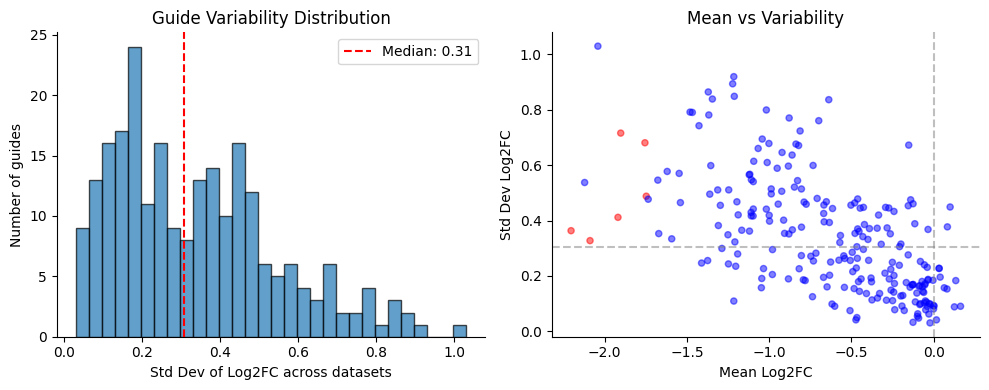

In [10]:
# Distribution of standard deviation across guides
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram of std
ax = axes[0]
ax.hist(complete_guides['std_log2fc'].dropna(), bins=30, edgecolor='black', alpha=0.7)
ax.set_xlabel('Std Dev of Log2FC across datasets')
ax.set_ylabel('Number of guides')
ax.set_title('Guide Variability Distribution')
ax.axvline(complete_guides['std_log2fc'].median(), color='red', linestyle='--', label=f"Median: {complete_guides['std_log2fc'].median():.2f}")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Scatter: mean vs std
ax = axes[1]
colors = [{'positive_control': 'red', 'tf_targeting': 'blue', 'negative_control': 'gray', 'non_targeting': 'lightgray'}.get(l, 'black') 
          for l in complete_guides['label']]
ax.scatter(complete_guides['mean_log2fc'], complete_guides['std_log2fc'], c=colors, alpha=0.5, s=20)
ax.set_xlabel('Mean Log2FC')
ax.set_ylabel('Std Dev Log2FC')
ax.set_title('Mean vs Variability')
ax.axhline(complete_guides['std_log2fc'].median(), color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "guide_variability_distribution.pdf", dpi=300, bbox_inches='tight')
plt.show()

## 2.3 Pairwise Dataset Comparison

For each pair of datasets, identify guides that perform differently.

In [11]:
# Calculate pairwise differences
pairwise_diffs = {}
for i, ds1 in enumerate(dataset_order):
    for j, ds2 in enumerate(dataset_order):
        if i >= j:
            continue
        col1, col2 = short_name(ds1), short_name(ds2)
        diff_col = f"{col1}_vs_{col2}"
        diff = log2fc_matrix[col1] - log2fc_matrix[col2]
        pairwise_diffs[diff_col] = diff

pairwise_df = pd.DataFrame(pairwise_diffs)
pairwise_df = pairwise_df.join(guide_meta)
pairwise_df.head()

,Hon_vs_Huangfu,Hon_vs_Gersbach GEM-Xv3,Hon_vs_Gersbach HTv2,Huangfu_vs_Gersbach GEM-Xv3,Huangfu_vs_Gersbach HTv2,Gersbach GEM-Xv3_vs_Gersbach HTv2,gene_name,label
guide_id,,,,,,,,
AFF4#chr5:132963540-132963558(+),0.721458,0.755931,-0.009795,0.034473,-0.731253,-0.765726,AFF4,tf_targeting
AFF4#chr5:132963567-132963585(+),0.502181,0.317168,-0.667855,-0.185012,-1.170036,-0.985023,AFF4,tf_targeting
AFF4#chr5:132963570-132963588(+),1.125924,0.790557,-0.001541,-0.335366,-1.127465,-0.792099,AFF4,tf_targeting
AFF4#chr5:132963573-132963591(+),0.093605,-0.075507,-0.138173,-0.169113,-0.231778,-0.062665,AFF4,tf_targeting
AFF4#chr5:132963579-132963597(-),0.140506,0.267178,0.119991,0.126672,-0.020515,-0.147187,AFF4,tf_targeting


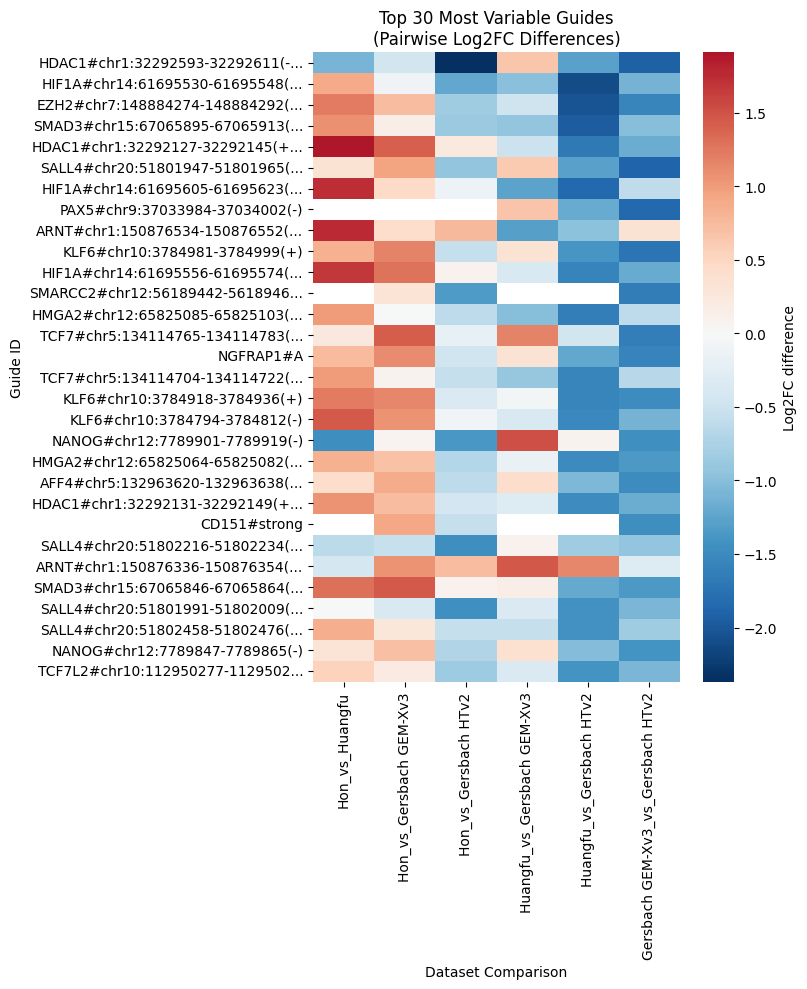

In [12]:
# Heatmap of pairwise differences for guides with large discrepancies
diff_cols = [c for c in pairwise_df.columns if '_vs_' in c]

# Find guides with largest absolute differences in any comparison
pairwise_df['max_abs_diff'] = pairwise_df[diff_cols].abs().max(axis=1)
top_variable = pairwise_df.nlargest(30, 'max_abs_diff')

# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 10))
plot_data = top_variable[diff_cols].copy()
plot_data.index = [f"{idx[:30]}..." if len(idx) > 30 else idx for idx in plot_data.index]

sns.heatmap(plot_data, cmap='RdBu_r', center=0, ax=ax, 
            cbar_kws={'label': 'Log2FC difference'})
ax.set_title('Top 30 Most Variable Guides\n(Pairwise Log2FC Differences)')
ax.set_xlabel('Dataset Comparison')
ax.set_ylabel('Guide ID')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "guide_pairwise_diff_heatmap.pdf", dpi=300, bbox_inches='tight')
plt.show()

## 2.4 Technology-Specific Guide Performance

Identify guides that work well in specific technologies but not others.

In [13]:
# Define "good knockdown" threshold (log2FC < -0.5 is ~30% reduction)
KNOCKDOWN_THRESH = -0.5

# For each dataset, count guides with good knockdown
knockdown_summary = {}
for ds in dataset_order:
    col = short_name(ds)
    knockdown_summary[col] = (log2fc_matrix[col] < KNOCKDOWN_THRESH).sum()

print(f"Guides with log2FC < {KNOCKDOWN_THRESH} per dataset:")
for ds, count in knockdown_summary.items():
    print(f"  {ds}: {count}")

Guides with log2FC < -0.5 per dataset:
  Hon: 120
  Huangfu: 152
  Gersbach GEM-Xv3: 159
  Gersbach HTv2: 97


In [14]:
# Find guides that work in only one dataset
ds_cols = [short_name(ds) for ds in dataset_order]

for ds in dataset_order:
    col = short_name(ds)
    other_cols = [c for c in ds_cols if c != col]
    
    # Guides with good knockdown in this dataset but not others
    good_here = log2fc_matrix[col] < KNOCKDOWN_THRESH
    bad_elsewhere = (log2fc_matrix[other_cols] >= KNOCKDOWN_THRESH).all(axis=1)
    exclusive = log2fc_matrix[good_here & bad_elsewhere]
    
    print(f"\n{col}-exclusive good knockdowns: {len(exclusive)}")
    if len(exclusive) > 0:
        print(exclusive[ds_cols + ['gene_name', 'label']].head())


Hon-exclusive good knockdowns: 7
                                         Hon   Huangfu  Gersbach GEM-Xv3  \
guide_id                                                                   
CLOCK#chr4:55546817-55546835(-)    -0.639521 -0.458352         -0.290444   
NANOG#chr12:7789867-7789885(-)     -0.728269  0.022475         -0.213227   
POU5F1#chr6:31170702-31170720(-)   -0.528409 -0.485765         -0.047131   
SMARCB1#chr22:23787031-23787049(+) -0.662284  0.021856         -0.068519   
SMARCD1#chr12:50085411-50085429(+) -0.589832 -0.417836         -0.364199   

                                    Gersbach HTv2 gene_name         label  
guide_id                                                                   
CLOCK#chr4:55546817-55546835(-)         -0.416790     CLOCK  tf_targeting  
NANOG#chr12:7789867-7789885(-)          -0.356761     NANOG  tf_targeting  
POU5F1#chr6:31170702-31170720(-)         0.442247    POU5F1  tf_targeting  
SMARCB1#chr22:23787031-23787049(+)       0.249158   S

## 2.5 Missing/Undetected Guides

Guides with NaN values may indicate poor capture in that technology.

In [15]:
# For each dataset, find guides that are NaN (not detected/tested)
missing_summary = {}
for ds in dataset_order:
    col = short_name(ds)
    missing = log2fc_matrix[col].isna()
    missing_summary[col] = missing.sum()
    
print("Guides with missing (NaN) log2FC per dataset:")
for ds, count in missing_summary.items():
    total = len(log2fc_matrix)
    print(f"  {ds}: {count} / {total} ({100*count/total:.1f}%)")

Guides with missing (NaN) log2FC per dataset:
  Hon: 174 / 416 (41.8%)
  Huangfu: 170 / 416 (40.9%)
  Gersbach GEM-Xv3: 156 / 416 (37.5%)
  Gersbach HTv2: 114 / 416 (27.4%)


In [16]:
# Create a detection matrix for upset plot or summary
detection_matrix = log2fc_matrix[ds_cols].notna().astype(int)
detection_matrix['pattern'] = detection_matrix.apply(lambda x: ''.join(x.astype(str)), axis=1)
detection_matrix = detection_matrix.join(guide_meta)

print("\nDetection patterns (1=detected, 0=missing):")
pattern_counts = detection_matrix['pattern'].value_counts()
for pattern, count in pattern_counts.items():
    labels = [ds_cols[i] for i, c in enumerate(pattern) if c == '1']
    print(f"  {pattern}: {count} guides - detected in: {', '.join(labels) if labels else 'none'}")


Detection patterns (1=detected, 0=missing):
  1111: 234 guides - detected in: Hon, Huangfu, Gersbach GEM-Xv3, Gersbach HTv2
  0000: 114 guides - detected in: none
  0001: 42 guides - detected in: Gersbach HTv2
  0111: 12 guides - detected in: Huangfu, Gersbach GEM-Xv3, Gersbach HTv2
  1011: 8 guides - detected in: Hon, Gersbach GEM-Xv3, Gersbach HTv2
  0011: 6 guides - detected in: Gersbach GEM-Xv3, Gersbach HTv2


In [17]:
# Save detection matrix
detection_matrix.to_csv(OUTPUT_DIR / "guide_detection_matrix.tsv", sep="\t")
print(f"Saved to {OUTPUT_DIR / 'guide_detection_matrix.tsv'}")

Saved to /Users/adamklie/Desktop/projects/tf_perturb_seq/datasets/technology-benchmark_WTC11_TF-Perturb-seq/results/cross_tech_comparison/guide_detection_matrix.tsv


## 2.6 Trans Effects Comparison (Optional)

Compare the number of significant trans effects per guide across datasets.

In [18]:
# Try to load trans per-guide summary files
trans_list = []
for _, row in paths_df.iterrows():
    # Look for trans_per_guide_summary in the qc_dir/trans/ folder
    trans_dir = Path(row['qc_dir']) / 'trans'
    if trans_dir.exists():
        for f in trans_dir.glob('*_trans_per_guide_summary.tsv'):
            df = pd.read_csv(f, sep="\t")
            df['dataset'] = row['dataset']
            trans_list.append(df)
            break

if trans_list:
    trans_summary_df = pd.concat(trans_list, ignore_index=True)
    print(f"Loaded trans summary for {len(trans_list)} datasets")
    print(trans_summary_df.head())
else:
    print("No trans per-guide summary files found")
    trans_summary_df = None

Loaded trans summary for 4 datasets
                           guide_id  n_tests  n_significant_trans  \
0  AFF4#chr5:132963540-132963558(+)   9396.0                311.0   
1  AFF4#chr5:132963567-132963585(+)   9396.0                603.0   
2  AFF4#chr5:132963570-132963588(+)   9396.0               1291.0   
3  AFF4#chr5:132963573-132963591(+)   9396.0                453.0   
4  AFF4#chr5:132963579-132963597(-)   9396.0                 81.0   

   n_upregulated  n_downregulated  median_log2fc  mean_log2fc  max_abs_log2fc  \
0          246.0             65.0      -0.008872    -0.002430        0.986269   
1          439.0            164.0       0.009049     0.017430        0.805684   
2          548.0            743.0      -0.104645    -0.070690        1.025755   
3          246.0            207.0      -0.046324    -0.051710        1.254255   
4           71.0             10.0       0.005592     0.006003        1.155631   

   frac_significant gene_name         label  \
0          0.03

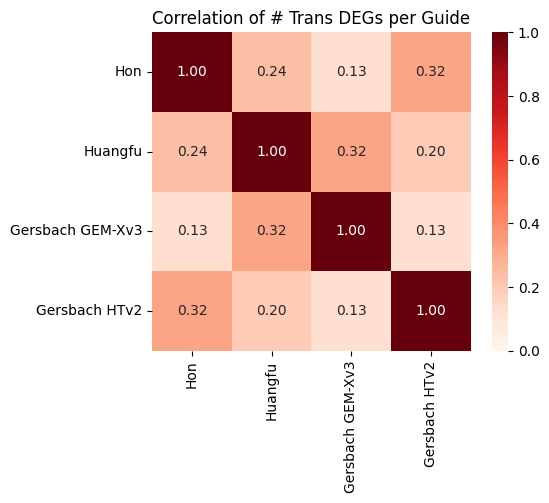

In [19]:
if trans_summary_df is not None:
    # Pivot to get n_significant_trans matrix
    trans_matrix = trans_summary_df.pivot(index='guide_id', columns='dataset', values='n_significant_trans')
    trans_matrix = trans_matrix[dataset_order]
    trans_matrix.columns = [short_name(c) for c in trans_matrix.columns]
    
    # Correlation of trans effects across datasets
    trans_corr = trans_matrix.corr()
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(trans_corr, annot=True, cmap='Reds', vmin=0, vmax=1, square=True, fmt='.2f')
    plt.title('Correlation of # Trans DEGs per Guide')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "trans_effects_correlation.pdf", dpi=300, bbox_inches='tight')
    plt.show()

---
# DONE!